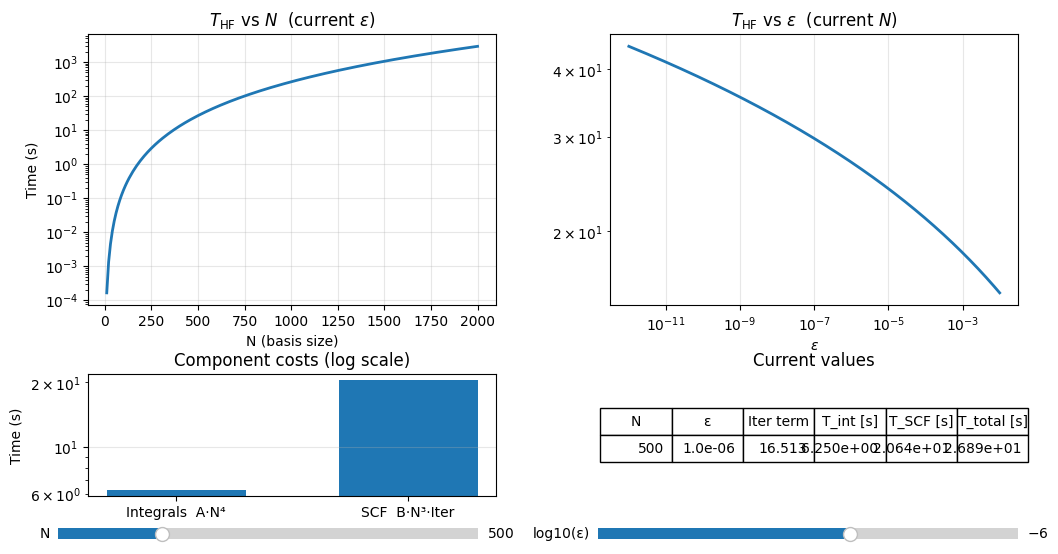

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# ------------------ Constants ------------------
A = 1e-10      # per-integral prefactor
B = 1e-8       # per-iteration prefactor (diag+Fock)
alpha = 1.0    # iteration convergence rate
beta = 5.0     # minimum SCF iterations
E0 = 1e-1      # initial SCF error (Ha)

# ------------------ Model ------------------
def iter_term(eps):
    # vectorized, works for scalars or arrays
    return np.maximum(0.0, alpha * np.log(E0 / eps)) + beta

def T_total(N, eps):
    return A * N**4 + B * N**3 * iter_term(eps)

def T_integrals(N):
    return A * N**4

def T_scf(N, eps):
    return B * N**3 * iter_term(eps)

# ------------------ Figure layout ------------------
plt.close("all")
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[4, 1.8], wspace=0.28, hspace=0.35)

axN   = fig.add_subplot(gs[0, 0])   # T vs N
axE   = fig.add_subplot(gs[0, 1])   # T vs eps
axBar = fig.add_subplot(gs[1, 0])   # separate bars (no stacking)
axTbl = fig.add_subplot(gs[1, 1])   # numeric table

# ------------------ Defaults ------------------
N0 = 500
logeps0 = -6.0
eps0 = 10**logeps0

# ------------------ Left plot: T vs N ------------------
Nmin, Nmax = 10, 2000
Ns = np.arange(Nmin, Nmax + 1, 10)
lineN, = axN.plot(Ns, T_total(Ns, eps0), lw=2)
axN.set_title(r"$T_{\rm HF}$ vs $N$  (current $\varepsilon$)")
axN.set_xlabel("N (basis size)")
axN.set_ylabel("Time (s)")
axN.set_yscale("log")
axN.grid(True, alpha=0.3)

# ------------------ Right plot: T vs eps ------------------
logeps_min, logeps_max = -12, -2
logeps = np.linspace(logeps_min, logeps_max, 600)
eps_grid = 10**logeps
lineE, = axE.plot(eps_grid, T_total(N0, eps_grid), lw=2)
axE.set_xscale("log")
axE.set_yscale("log")
axE.set_xlabel(r"$\varepsilon$")
axE.set_title(r"$T_{\rm HF}$ vs $\varepsilon$  (current $N$)")
axE.grid(True, alpha=0.3)

# ------------------ Bottom row helpers ------------------
def draw_bottom(N_val, eps_val):
    # ---- Bars (separate; log y) ----
    axBar.clear()
    ti = T_integrals(N_val)
    ts = T_scf(N_val, eps_val)
    axBar.bar([0, 1], [ti, ts], width=0.6)
    axBar.set_xticks([0, 1], ["Integrals  A·N⁴", "SCF  B·N³·Iter"])
    axBar.set_ylabel("Time (s)")
    axBar.set_yscale("log")
    axBar.grid(True, axis="y", alpha=0.3)
    axBar.set_title("Component costs (log scale)")

    # ---- Table (clean readout) ----
    axTbl.clear()
    axTbl.axis("off")
    it = iter_term(eps_val)
    tt = ti + ts
    cols = ["N", "ε", "Iter term", "T_int [s]", "T_SCF [s]", "T_total [s]"]
    row = [f"{int(N_val)}", f"{eps_val:.1e}", f"{it:.3f}",
           f"{ti:.3e}", f"{ts:.3e}", f"{tt:.3e}"]
    table = axTbl.table(cellText=[row], colLabels=cols, loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.05, 1.6)
    axTbl.set_title("Current values")

draw_bottom(N0, eps0)

# ------------------ Sliders ------------------
axN_slider   = fig.add_axes([0.10, 0.03, 0.35, 0.035])
axEps_slider = fig.add_axes([0.55, 0.03, 0.35, 0.035])

sN = Slider(axN_slider, "N", Nmin, Nmax, valinit=N0, valstep=10)
sLogEps = Slider(axEps_slider, r"log10(ε)", logeps_min, logeps_max, valinit=logeps0)

# ------------------ Update ------------------
def update(_):
    Nval = int(sN.val)
    epsval = 10**(sLogEps.val)

    # update curves
    lineN.set_ydata(T_total(Ns, epsval))
    lineE.set_ydata(T_total(Nval, eps_grid))

    # update bars + table
    draw_bottom(Nval, epsval)

    fig.canvas.draw_idle()

sN.on_changed(update)
sLogEps.on_changed(update)

plt.show()
